# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27457182 entries, 0 to 27457181
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 837.9 MB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,2.745718e+07,2.745718e+07,2.745718e+07,2.745718e+07,2.745718e+07,2.745718e+07,2.745718e+07
mean,3.045635e+00,8.924166e-01,3.522059e-01,9.710742e-01,6.885320e-01,8.597587e-02,5.543038e-02
std,7.523652e+00,3.772060e+00,5.678583e-01,2.690768e+00,7.574100e-01,1.129915e+00,2.370340e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.770600e+04,8.333000e+03,6.120000e+02,5.104000e+03,2.368000e+03,3.118000e+03,8.800000e+01


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          27457182
n_isbns          13006530
n_loc_recs        9314949
n_ol_editions    20525938
n_ol_works       17723537
n_gr_books        1509384
n_gr_works        1508860
dtype: int64

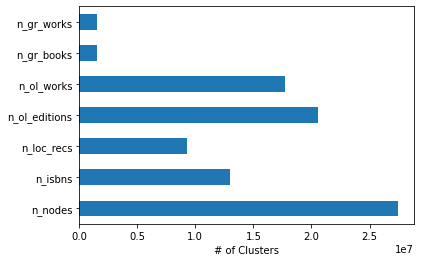

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.

In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,14450652
1,n_isbns,2,6218531
2,n_isbns,1,5590300
3,n_isbns,4,544461
4,n_isbns,3,317043


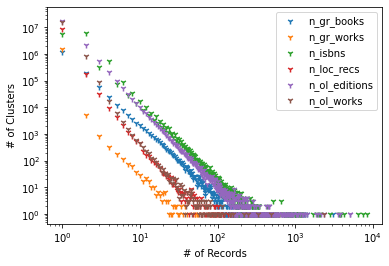

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6962 entries, 100004141 to 102572553
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        6962 non-null   uint32
 1   n_isbns        6962 non-null   uint32
 2   n_loc_recs     6962 non-null   uint32
 3   n_ol_editions  6962 non-null   uint32
 4   n_ol_works     6962 non-null   uint32
 5   n_gr_books     6962 non-null   uint32
 6   n_gr_works     6962 non-null   uint32
dtypes: uint32(7)
memory usage: 244.8 KB


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?

In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.00025355843145155973

Less than 1%. Not bad, but let's look.

In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100004141,17706,8333,612,5066,489,3118,88
100066430,11065,3872,409,5104,332,1269,79
100307111,448,163,4,91,74,60,56
100162584,873,327,67,269,75,81,54
100092083,1117,428,61,231,145,200,52


## Huge Cluster Debugging

We have a very large cluster:

In [12]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100004141,17706,8333,612,5066,489,3118,88
105723403,11281,7520,0,3760,1,0,0
100066430,11065,3872,409,5104,332,1269,79
100379578,10132,6518,7,3572,35,0,0
100089994,7289,3727,162,1839,113,1421,27


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?

In [13]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,loc_recs,ol_recs,gr_recs,bx_recs,az_recs
isbn_id,,,,,,
1912306,0883448319,1,2,0,0,0
6527222,9781573126892,2,0,0,0,0
14152572,9781932382778,0,1,1,0,0
1966693,1880353032,1,1,0,0,0
314941,0853152004,1,1,0,0,0


In [14]:
links = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
links.head()

,isbn_id,cluster
0,9227577,106627775
1,16248168,111588622
2,24467661,924467661
3,22217256,451841168
4,11107969,103205979


In [15]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].drop(columns=['cluster'])
bl = bl.join(isbns, on='isbn_id')
bl.sort_values('isbn')

,isbn_id,isbn,loc_recs,ol_recs,gr_recs,bx_recs,az_recs
24449245,8904736,0001004735,0,1,0,0,0
24444675,17818548,0001848259,0,1,0,0,0
24448488,11564794,0003708853,0,2,0,0,0
24443881,9646896,0004214072,0,2,0,0,0
24449376,12108303,0004214501,0,1,0,0,0
...,...,...,...,...,...,...,...
24444455,22257781,B07381C14X,0,0,1,0,0
24447278,22039122,B073GF59RD,0,0,1,0,0
24447706,22310225,B073GGNYFL,0,0,1,0,0
24448850,22122099,B074P9CM5T,0,0,1,0,0


GoodReads gives us some wacky ISBNs.  Are there any of these that have a really large record count?

In [16]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn_id,isbn,loc_recs,ol_recs,gr_recs,bx_recs,az_recs,btot
24446499,7214985,1559029838,0,12,1,180,0,13
24446500,7214986,9781559029834,0,11,0,0,0,11
24448645,871160,0394848284,3,6,0,2,4,9
24443953,4145077,9781402726019,3,4,1,0,0,8
24445304,1395236,0716631970,4,4,0,0,0,8
24447100,8107936,1577595394,0,7,1,0,0,8
24447386,4828587,9780192727992,1,6,1,0,0,8
24443958,4145078,1402726015,2,4,1,0,31,7
24447097,8107938,9781577595397,0,6,1,0,0,7
24450546,5108168,9780674035751,1,6,0,0,0,7
